## Experiment with flight data APIs

Initial goal: compare deterministic optimal (cheapest) flight search to agent-driven one

In [52]:
from utils.utils import get_flights_to_destinations, plot_price_distribution

import nest_asyncio
nest_asyncio.apply()

import json
import pandas as pd
from datetime import datetime

from dotenv import load_dotenv
load_dotenv()

from openai import AsyncOpenAI
client = AsyncOpenAI()
from langchain_core.utils.function_calling import convert_to_openai_tool

from IPython.display import Markdown, display

import warnings
warnings.filterwarnings("ignore")

Test query with the function

In [3]:
flights_df = get_flights_to_destinations(
    date="2025-05-02",
    from_airport="EWR",
    to_airports=[
        "ORY",  # Orly
        "BVA",  # Beauvais
        "CDG",  # Charles de Gaulle
    ],
    max_stops=1,
    #trip="one-way",
    #passengers_adults=2,
)

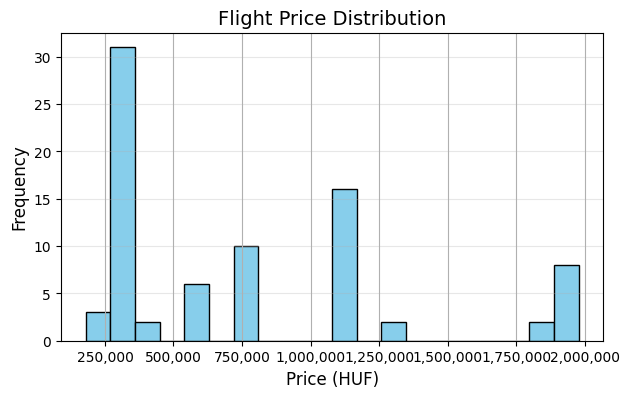

In [4]:
fig = plot_price_distribution(flights_df)

In [5]:
pd.DataFrame(flights_df['name'].value_counts())

,count
name,
Tap Air Portugal,32
Delta,17
"Delta, Air France",10
"United, Tap Air Portugal",8
French bee,2
Self transferThis trip includes tickets from multiple airlines. Missed connections may be protected by the booking provider.,2
LOT,2
La Compagnie,2
Icelandair,2


In [6]:
flights_df.head(3)

,price,departure_date,departure_time,arrival_date,arrival_time,duration_hours,name,stops,is_best,price_denomination
0,179194,2025-05-02,23:00,2025-05-03,12:15,7.250,French bee,0,True,HUF
1,403642,2025-05-02,20:25,2025-05-03,21:55,19.500,Self transferThis trip includes tickets from m...,1,True,HUF
2,601430,2025-05-02,20:20,2025-05-03,19:25,17.083,LOT,1,True,HUF


### General tool-calling agent

Showcasing tool calling capabilities by assigning the above function as a tool to an OpenAI model. Tool will return with the pandas under the hood, the AI will analyze the content and provide an answer

1. Set up custom tool

In [28]:
def convert_to_openai_tool_format(func):
    """
    Convert a function to the OpenAI tool format with the correct structure.
    """
    # Get the original tool definition
    tool_def = convert_to_openai_tool(func)
    
    # Restructure to match the required format
    return {
        "type": "function",
        "name": tool_def["function"]["name"],
        "description": tool_def["function"]["description"],
        "parameters": tool_def["function"]["parameters"]
    }

get_flights = convert_to_openai_tool_format(get_flights_to_destinations)
print(json.dumps(get_flights, indent=4))

{
    "type": "function",
    "name": "get_flights_to_destinations",
    "description": "Fetch flights to multiple destinations and return a combined DataFrame. Note: The fast_flights API doesn't support multiple destinations in a single call,\nso this function makes separate API calls for each destination and combines the results.",
    "parameters": {
        "type": "object",
        "properties": {
            "date": {
                "description": "Flight date in YYYY-MM-DD format",
                "type": "string"
            },
            "from_airport": {
                "description": "Departure airport code in IATA format (3-letter codes), such as \"BUD\"",
                "type": "string"
            },
            "to_airports": {
                "description": "List of destination airport codes in IATA format (3-letter codes), such as [\"CDG\", \"ORY\", \"BVA\"]",
                "type": "array",
                "items": {
                    "type": "string"
          

2. Set up OpenAI responses API wrapper

In [86]:
system_message = "You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability."

user_message_template = """
<current_datetime>
The current date and time is {current_datetime}.
</current_datetime>

<instructions>
Your sole purpose is to answer user's questions. You aim to be informative and helpful, providing concise but complete answers. The user may ask you any questions. For general questions, use your own knowledge. For flight information, use the available tools.
</instructions>

<user_question>
{question}
</user_question>
"""

async def ai(question: str, tools=[get_flights], stream=False, model="gpt-4.1"):

    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M')
    
    if stream:
        # Streaming
        stream_response = await client.responses.create(
            model=model,
            input=[
                {"role": "system", "content": system_message},
                {
                    "role": "user", 
                    "content": user_message_template.format(
                        question=question, 
                        current_datetime=current_datetime
                        )        
                },
            ],
            tools=tools,
            stream=True,
        )

        text_chunks = []
        md_display = display(Markdown(""), display_id=True)

        async for event in stream_response:
            #if hasattr(event, "type") and "text.delta" in event.type:
            #    text_chunks.append(event.delta)
            #    #print(event.delta, end="", flush=True)
            #    md_display.update(Markdown("".join(text_chunks)))
            #print(event)
            text_chunks.append(event)
        
        return text_chunks[-1].response #"".join(text_chunks)
    
    else:
        response = await client.responses.create(
            model=model,
            input=[
                {"role": "system", "content": system_message},
                {
                    "role": "user", 
                    "content": user_message_template.format(
                        question=question, 
                        current_datetime=current_datetime
                        )        
                },
            ],
            tools=tools,
        )

        return response#.output_text

Simple test

In [59]:
q = 'what is the difference between declarative and imperative?'
a = await ai(q, stream=True)

The difference between declarative and imperative generally refers to two different approaches to programming and problem-solving:

**Imperative:**
- You tell the system exactly how to do something, step-by-step.
- Focuses on *how* the task should be accomplished.
- The code describes the control flow (the steps to achieve the result).
- Examples: C, Java (traditional usage), Python (when used with loops and explicit assignments).
- Example code (imperative way to sum numbers in an array):

  ```python
  total = 0
  for num in numbers:
      total += num
  ```

**Declarative:**
- You tell the system *what* you want, not *how* to do it.
- Focuses on describing the desired result.
- The code expresses the logic of computation without describing its control flow.
- Examples: SQL, HTML, React (to some extent), functional programming (like Haskell).
- Example code (declarative way to sum numbers in an array):

  ```python
  total = sum(numbers)
  ```

**Summary:**  
- Imperative: How to do it (explicit instructions).
- Declarative: What you want (specify result, not process).

In [63]:
#display(Markdown(a))

Test with flight related question

In [91]:
q = 'How much would it cost to fly from Budapest to London on 2025-04-25?'
a = await ai(q, stream=True)

In [92]:
a.output[0].__dict__

{'id': 'fc_68057dab715c819280f0efab03046b6609e9b37c3fbd086a',
 'arguments': '{"date":"2025-04-25","from_airport":"BUD","to_airports":["LHR","LGW","LTN","STN","LCY"]}',
 'call_id': 'call_AEJTQMEXbe22QYrk3dyCz1I1',
 'name': 'get_flights_to_destinations',
 'type': 'function_call',
 'status': 'completed'}